In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from yahoofinancials import YahooFinancials
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_FoxNews_comments_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,CommentID,CommentDate,CommenterURL,CommentText,WNPositive,WNNegative,WNNeutral,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,1.016072e+16,2021-05-31 19:06:00,10160717141986336,2021-05-31 00:00:00,profile.php?id=100049838682322&fref=nf&rc=p&r...,Sorry for your loss. He will always be remembe...,0.000000,0.250000,3.750000,...,5,-0.400000,0,2,5,-0.400000,0.126,0.216,0.659,-0.1280
1,1,1.016072e+16,2021-05-31 19:06:00,10160717198346336,2021-05-31 00:00:00,tom.petrick.96?fref=nf&rc=p&refid=52&__tn__=R,"Rest in Peace, soldier, and may God Bless his ...",0.875000,0.000000,4.125000,...,5,0.400000,0,0,5,0.000000,0.634,0.000,0.366,0.9022
2,2,1.016072e+16,2021-05-31 19:06:00,10160717252036336,2021-05-31 00:00:00,profile.php?id=100067824624611&fref=nf&rc=p&r...,Son ángeles rresignadion para su familia amen,0.000000,0.000000,3.000000,...,5,0.200000,0,0,5,0.000000,0.000,0.000,1.000,0.0000
3,3,1.016072e+16,2021-05-31 19:06:00,10160717353421336,2021-05-31 00:00:00,chicks1950?fref=nf&rc=p&refid=52&__tn__=R,So sorry you lost your son. Prayers to you and...,1.121751,1.036144,6.842105,...,11,0.090909,1,2,11,-0.090909,0.080,0.214,0.706,-0.4865
4,4,1.016072e+16,2021-05-31 19:06:00,10160717374471336,2021-05-31 00:00:00,gaile.jones.35?fref=nf&rc=p&refid=52&__tn__=R,God Bless our fallen soldiers. God Bless Ameri...,0.000000,0.000000,6.000000,...,7,0.142857,0,0,7,0.000000,0.525,0.103,0.372,0.8478


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

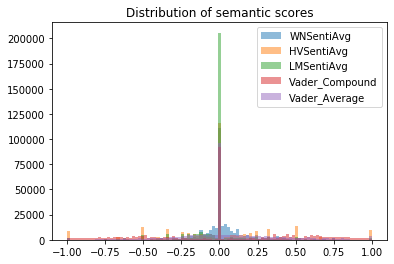

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

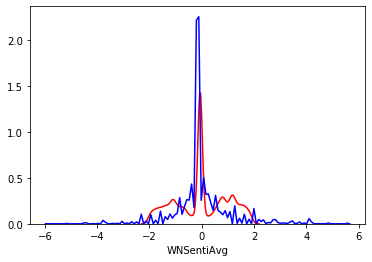

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [8]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,305713.000000,305713.000000,305713.000000,305713.000000,305713.000000
mean,0.027981,0.007817,-0.027696,0.031826,0.038621
std,0.174430,0.346595,0.169648,0.500568,0.317384
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.017857,-0.111111,0.000000,-0.340000,-0.088000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.062500,0.142857,0.000000,0.440400,0.171000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [10]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [11]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'CommentID', 'CommentDate', 'CommenterURL',
       'CommentText', 'WNPositive', 'WNNegative', 'WNNeutral', 'WNSentiment',
       'WNTokenQnt', 'WNSentiAvg', 'HVPositive', 'HVNegative', 'HVTokenQnt',
       'HVSentiAvg', 'LMPositive', 'LMNegative', 'LMTokenQnt', 'LMSentiAvg',
       'Vader_Positive', 'Vader_Negative', 'Vader_Neutral', 'Vader_Compound',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [12]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [13]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [14]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.7008
p-value                           0.0000
#Lags Used                        5.0000
Number of Observations Used    1325.0000
Critical Value (1%)              -3.4353
Critical Value (5%)              -2.8637
Critical Value (10%)             -2.5679
dtype: float64


In [16]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -9.3448
p-value                           0.0000
#Lags Used                        9.0000
Number of Observations Used    1321.0000
Critical Value (1%)              -3.4353
Critical Value (5%)              -2.8637
Critical Value (10%)             -2.5679
dtype: float64


In [17]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -9.3448
p-value                           0.0000
#Lags Used                        9.0000
Number of Observations Used    1321.0000
Critical Value (1%)              -3.4353
Critical Value (5%)              -2.8637
Critical Value (10%)             -2.5679
dtype: float64
Results of Dickey-Fuller Test:


In [18]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -10.0267
p-value                           0.0000
#Lags Used                        8.0000
Number of Observations Used    1322.0000
Critical Value (1%)              -3.4353
Critical Value (5%)              -2.8637
Critical Value (10%)             -2.5679
dtype: float64
Results of Dickey-Fuller Test:


In [19]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2012-04-25,-0.505128,51,-0.112894,-0.080176,134,139,833,12,61,833,-0.009904,-0.006002,-0.058824
2012-04-26,-0.590616,49,0.039663,0.038837,175,132,1146,16,49,1146,-0.012053,0.037522,-0.028796
2012-04-27,0.526024,25,0.164220,0.077280,86,77,639,9,24,639,0.021041,0.014085,-0.023474
2012-04-28,3.689543,84,0.033498,0.042512,136,132,1046,12,60,1046,0.043923,0.003824,-0.045889
2012-04-29,-1.008734,55,-0.112620,-0.067164,407,355,2709,57,197,2709,-0.018341,0.019195,-0.051680


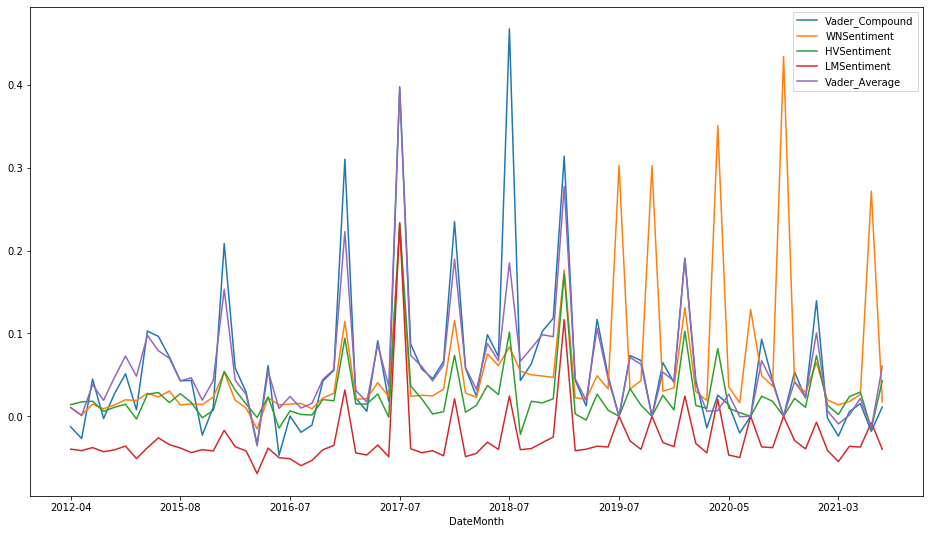

In [20]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [33]:
#SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
#SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')
yahoo_financials = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','daily')
SnP_daily =pd.DataFrame(yahoo_financials["^GSPC"]["prices"])
SnP_daily.index = SnP_daily['formatted_date']
SnP_daily['LogReturn'] = np.log(SnP_daily['adjclose']/SnP_daily['adjclose'].shift(1))

yahoo_financials_m = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','monthly')
SnP_monthly =pd.DataFrame(yahoo_financials_m["^GSPC"]["prices"])
SnP_monthly.index = SnP_monthly['formatted_date']
SnP_monthly['LogReturn'] = np.log(SnP_monthly['adjclose']/SnP_monthly['adjclose'].shift(1))


In [34]:
#SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [35]:
#SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [36]:
#SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [37]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [38]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [39]:
#Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [40]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [41]:
#Granger_data_monthly

In [42]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7147  , p=0.3986  , df_denom=294, df_num=1
ssr based chi2 test:   chi2=0.7220  , p=0.3955  , df=1
likelihood ratio test: chi2=0.7212  , p=0.3958  , df=1
parameter F test:         F=0.7147  , p=0.3986  , df_denom=294, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5665  , p=0.5681  , df_denom=291, df_num=2
ssr based chi2 test:   chi2=1.1525  , p=0.5620  , df=2
likelihood ratio test: chi2=1.1503  , p=0.5626  , df=2
parameter F test:         F=0.5665  , p=0.5681  , df_denom=291, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5980  , p=0.6168  , df_denom=288, df_num=3
ssr based chi2 test:   chi2=1.8376  , p=0.6068  , df=3
likelihood ratio test: chi2=1.8319  , p=0.6080  , df=3
parameter F test:   

C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


ssr based chi2 test:   chi2=6.6684  , p=0.3526  , df=6
likelihood ratio test: chi2=6.5934  , p=0.3601  , df=6
parameter F test:         F=1.0619  , p=0.3857  , df_denom=279, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0077  , p=0.4259  , df_denom=276, df_num=7
ssr based chi2 test:   chi2=7.4375  , p=0.3848  , df=7
likelihood ratio test: chi2=7.3441  , p=0.3940  , df=7
parameter F test:         F=1.0077  , p=0.4259  , df_denom=276, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9305  , p=0.4916  , df_denom=273, df_num=8
ssr based chi2 test:   chi2=7.9079  , p=0.4425  , df=8
likelihood ratio test: chi2=7.8020  , p=0.4530  , df=8
parameter F test:         F=0.9305  , p=0.4916  , df_denom=273, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8139  , p=0.6038  , df_denom=270, df_num=9
ssr based chi2 test:   chi2=7.8407  , p=0.5503  , df=9
likelihood ratio test: chi2=7.7362  , p

Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8625  , p=0.3538  , df_denom=294, df_num=1
ssr based chi2 test:   chi2=0.8713  , p=0.3506  , df=1
likelihood ratio test: chi2=0.8701  , p=0.3509  , df=1
parameter F test:         F=0.8625  , p=0.3538  , df_denom=294, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5085  , p=0.6019  , df_denom=291, df_num=2
ssr based chi2 test:   chi2=1.0346  , p=0.5961  , df=2
likelihood ratio test: chi2=1.0328  , p=0.5967  , df=2
parameter F test:         F=0.5085  , p=0.6019  , df_denom=291, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3590  , p=0.7827  , df_denom=288, df_num=3
ssr based chi2 test:   chi2=1.1031  , p=0.7763  , df=3
likelihood ratio test: chi2=1.1010  , p=0.7768  , df=3
parameter F test:         F=0.3590  , p=0.7827  , df_denom=288, df_num=3

Grang

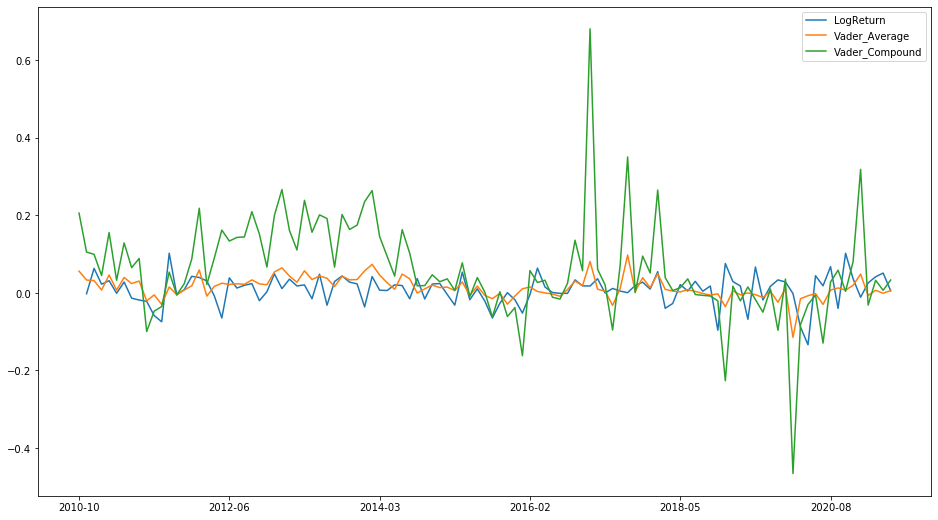

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [43]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.932693,0.080362,0.666828,0.418433,0.038313
Vader_Average,0.932693,1.000000,0.037370,0.583740,0.350280,0.019549
WNSentiment,0.080362,0.037370,1.000000,0.021909,0.488264,0.113871
HVSentiment,0.666828,0.583740,0.021909,1.000000,0.572668,-0.000091
LMSentiment,0.418433,0.350280,0.488264,0.572668,1.000000,0.051309
LogReturn,0.038313,0.019549,0.113871,-0.000091,0.051309,1.000000


In [44]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
corr_signif

,p-value
Vader_Compound,0.510868
Vader_Average,0.744938
WNSentiment,0.048039
HVSentiment,0.998316
LMSentiment,0.368807


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
